# 유전체 정보 품종 분류 AI 경진대회
## [Private 1위] CatboostEncoder+OverSampling+VotingClassifier 코드 리뷰
- 작성자: 국민대민쑤 외 2인

- EDA: 클래스간 불균형이 존재하여 OverSamplig 및 UnderSampling을 진행하였고, 모델에서 class_weight와 sample_weight를 조절하며 실험한 결과 BorderlineSmote를 사용하는 것이 가장 효과적이었다. 
- 분석 방법: 데이터셋이 작고 multiclass인 특성으로 앙상블을 통해 일반화 성능을 높였다.
- 인코딩: Catboost Encoder을 사용하였다. 
- 앙상블 모델: sklearn에 내장된 classifier 및 boosting 계열 모델과 딥러닝 모델 중 효과가 좋은 9개의 모델을 선별하여 사용하였다. 그 중딥러닝 모델은 성능이 좋지 않아 사용 모델에서 제외되었다.XGB classifier과 RandomForest classifier의 성능이 좋아 가중치를 높게 두었다. 최종적으로 모델들을 VotingClassifier를 이용하여 hard 앙상블을 이용하였다. 

## **코드 실행환경**

Google Colab

Sklearn 버전 : 1.0.2

Pandas 버전 : 1.3.5

Numpy 버전 : 1.21.6

런타임 유형 : GPU

Linux-5.10.147+-x86_64-with-glibc2.27

Ubuntu 18.04.6 LTS

Python 3.8.16

GPU : NVIDIA-SMI 460.32.03 Driver Version: 460.32.03 CUDA Version: 11.2 Tesla T4

In [1]:
import platform
platform.platform()

'macOS-10.16-x86_64-i386-64bit'

In [6]:
!cat /etc/issue.net

cat: /etc/issue.net: No such file or directory


In [7]:
!python --version

Python 3.10.4


In [8]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


구글 코랩 사용시 구글 드라이브 연결 사용

In [14]:
DATA_PATH = 'open/'

## Import & Install

In [4]:
# 코랩 기준 필요 라이브러리 설치

# Category_encoders 설치
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 251.8 kB/s eta 0:00:00 0:00:01


In [10]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 1.4 MB/s eta 0:00:00a 0:00:01


In [46]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.2 MB/s eta 0:00:0000:0100:01


In [52]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.2 MB/s eta 0:00:0000:0100:01


In [54]:
#Base & visualization
import pandas as pd
import random
import os
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns

#sklearn module & utils
from tqdm.notebook import tqdm
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import StratifiedKFold , KFold, train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectPercentile
warnings.filterwarnings('ignore') 

#Scaling
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encoding
import category_encoders as ce

#Sampling
from imblearn.over_sampling import BorderlineSMOTE

#Modeling
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.svm import SVC
from xgboost import XGBClassifier 


## Fix Seed

In [12]:
#Seed 고정
class CFG:
    SEED = 26

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

## Data Load

In [15]:
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
snp = pd.read_csv(DATA_PATH + 'snp_info.csv')

In [18]:
train.head()

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,...,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,0,0,0,2,G G,A G,A A,G A,C A,...,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,0,0,0,2,A G,A G,C A,A A,A A,...,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,0,0,0,2,G G,G G,A A,G A,C C,...,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_003,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G G,A G,G G,G G,G G,A A,G G,A
4,TRAIN_004,0,0,0,2,G G,G G,C C,A A,C C,...,A A,A A,A A,G G,A A,A A,A G,A A,G A,C


In [19]:
test.head()

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,TEST_000,0,0,0,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,A G,A G,G A,G G,C A,G A
1,TEST_001,0,0,0,2,G G,A G,C C,G G,C C,A A,A A,A A,A A,G G,A G,A A,A A,A A,A A
2,TEST_002,0,0,0,2,G G,A G,A A,A A,C A,A G,A A,A A,A A,A G,A A,G A,G G,A A,G G
3,TEST_003,0,0,0,2,G G,A G,C A,A A,C C,A A,A A,A A,A A,G G,A A,G A,A G,A A,A A
4,TEST_004,0,0,0,1,A A,G G,A A,G G,A A,G G,G G,A A,G G,A G,G G,G A,G G,A A,G G


In [20]:
snp.head()

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.0546,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.1567,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.2892,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.8749,53826064
4,SNP_05,BovineHD0600017032,6,80.5015,61779512


## EDA

In [16]:
#X Y 데이터분리 및 id column drop
def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['id', 'class'])
        df_y = df['class']
        return df_x, df_y
    else:
        df_x = df.drop(columns=['id'])
        return df_x

train_x, train_y = get_x_y(train)
test_x = get_x_y(test)

In [21]:
train_y

0      B
1      C
2      B
3      A
4      C
      ..
257    B
258    C
259    A
260    A
261    B
Name: class, Length: 262, dtype: object

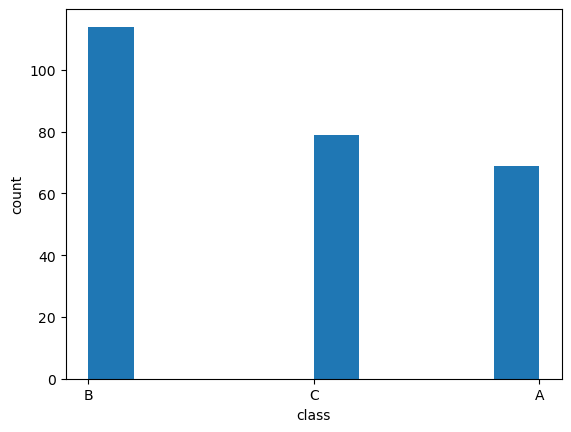

In [29]:
#class imbalanced -> Oversampling 적용

plt.hist(train_y)
plt.xlabel('class')
plt.ylabel('count')
plt.show()

## Data Pre-processing

In [30]:
#train_x 데이터를 확인해본 결과, 동일한 값을 가지는 columns 제거 -> 모델링에 좋지 않은 영향을 줄 것으로 판단 
train_x = train_x.drop(columns=['father','mother','gender'])
test_x = test_x.drop(columns=['father','mother','gender'])

## Feature Engineering

In [31]:
snp

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


*SNP 정보(name, chrom, cm, pos)를 활용하여 Feature Engineering을 진행하였습니다

1. name(SNP 명) & chrom(염색체 정보)
2. chrom(염색체 정보)
3. SNP Total combination
4. cm(Genetic distance)
5. SNP G,C,A mathematical feature

#### SNP 합

In [32]:
train_x['2_BTA'] = train_x['SNP_01']
train_x['chrom_6'] = train_x['SNP_02'] + '-'+ train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09']
train_x['6_ARS_Parent'] = train_x['SNP_02']
train_x['6_ARS_BFGL'] = train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_09']
train_x['6_BOVINE'] = train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_08']
train_x['6_HAPMAP'] = train_x['SNP_07']
train_x['7_BTB'] = train_x['SNP_10']
train_x['8_ARS'] = train_x['SNP_11']
train_x['chrom_9'] = train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14']
train_x['9_HAPMAP'] = train_x['SNP_12'] + '-' + train_x['SNP_14']
train_x['9_BTB'] = train_x['SNP_13']
train_x['10_BOVINE'] = train_x['SNP_15']
train_x['SNP_total'] = train_x['SNP_01'] + '-' + train_x['SNP_02'] + '-' + train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09'] + '-' + train_x['SNP_10'] + '-' + train_x['SNP_11'] + '-' + train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14'] + '-' + train_x['SNP_15']  

In [33]:
test_x['2_BTA'] = test_x['SNP_01']
test_x['chrom_6'] = test_x['SNP_02'] + '-'+ test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09']
test_x['6_ARS_Parent'] = test_x['SNP_02']
test_x['6_ARS_BFGL'] = test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_09']
test_x['6_BOVINE'] = test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_08']
test_x['6_HAPMAP'] = test_x['SNP_07']
test_x['7_BTB'] = test_x['SNP_10']
test_x['8_ARS'] = test_x['SNP_11']
test_x['chrom_9'] = test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14']
test_x['9_HAPMAP'] = test_x['SNP_12'] + '-' + test_x['SNP_14']
test_x['9_BTB'] = test_x['SNP_13']
test_x['10_BOVINE'] = test_x['SNP_15']
test_x['SNP_total'] = test_x['SNP_01'] + '-' + test_x['SNP_02'] + '-' + test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09'] + '-' + test_x['SNP_10'] + '-' + test_x['SNP_11'] + '-' + test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14'] + '-' + test_x['SNP_15'] 

#### 공백제거

In [34]:
def blank(data_tr, data_te, columns):
    for i in columns :
        data_tr[i] = data_tr[i].apply(lambda x : x.replace(" ",""))
        data_te[i] = data_te[i].apply(lambda x : x.replace(" ",""))
        
    return data_tr, data_te

target_columns = train_x.iloc[:,16:].columns.to_list()
train_x.iloc[:,16:], test_x.iloc[:,16:] = blank(train_x.iloc[:,16:], test_x.iloc[:,16:], target_columns)

#### SNP A,C,G 값 개수

In [35]:
train_x['concat'] = train_x.iloc[:,1:16].sum(axis=1).apply(lambda x : x.replace(" ",""))
train_x['numGC'] = train_x['concat'].apply(lambda x : x.count('C')+x.count('G'))
train_x['numA'] = train_x['concat'].apply(lambda x : x.count('A'))
train_x['numGC^2'] = train_x['numGC']**2
train_x['sub'] = train_x['numGC'] - train_x['numA']
train_x['H'] = train_x['numGC']*3 + train_x['numA']*2

In [36]:
test_x['concat'] = test_x.iloc[:,1:16].sum(axis=1).apply(lambda x : x.replace(" ",""))
test_x['numGC'] = test_x['concat'].apply(lambda x : x.count('C')+x.count('G'))
test_x['numA'] = test_x['concat'].apply(lambda x : x.count('A'))
test_x['numGC^2'] = test_x['numGC']**2
test_x['sub'] = test_x['numGC'] - test_x['numA']
test_x['H'] = test_x['numGC']*3 + test_x['numA']*2

#### trait 변수 type 변환

In [37]:
train_x['trait'] = train_x['trait'].astype('object')
test_x['trait'] = test_x['trait'].astype('object')

#### 범주형, 수치형 피처 구분

In [38]:
cat_features = train_x.select_dtypes(include=['object']).columns.to_list()
num_features = train_x.select_dtypes(exclude=['object']).columns.to_list()

## Scaling

In [39]:
scaler = StandardScaler()
train_x[num_features] = scaler.fit_transform(train_x[num_features])
test_x[num_features] = scaler.transform(test_x[num_features])

## Encoding

In [40]:
def catboost_encoder_multiclass(X,X_t,y):
    y = y.astype(str)
    enc = ce.OneHotEncoder().fit(y) # onehotencoding
    y_onehot = enc.transform(y)
    class_names = y_onehot.columns
    X_obj = X.select_dtypes('object')
    X_t_obj = X_t.select_dtypes('object')
    X = X.select_dtypes(exclude='object')
    X_t = X_t.select_dtypes(exclude='object') 
    for class_ in class_names:
        enc = ce.CatBoostEncoder() # catboost란? 
        enc.fit(X_obj,y_onehot[class_])
        temp = enc.transform(X_obj)
        temp_t = enc.transform(X_t_obj)
        temp.columns = [str(x)+'_'+str(class_) for x in temp.columns]
        temp_t.columns = [str(x)+'_'+str(class_) for x in temp_t.columns]
        X = pd.concat([X,temp],axis=1)
        X_t = pd.concat([X_t,temp_t],axis=1)
      
    return X, X_t

train_x, test_x = catboost_encoder_multiclass(train_x,test_x,train_y)

# Catboost
1. 기존 부스팅 모델의 문제
    - 느린 학습 속도: 배깅과 비교했을 때 훨씬 느린 속도를 보인다. 배깅의 경우 여러 트리들이 병렬적으로 모델을 학습하고, 부스팅의 경우 순차적으로 학습을 하기 때문이다.
    - 오버피팅의 문제: 부스팅 자체의 목적이 잔차를 줄여나가기 위해 학습하기 때문에, variance가 높은 모델이라는 문제가 있다. 

2. Catboost의 특징
    - level-wise-tree: XGBoost와 더불어 level-wise하게 트리를 만들어나간다. Level-wise는 BFS같이 트리를 만들어가는 형태이다. 
    - Ordered Boostiong: 기존의 부스팅 모델이 일괄적으로 모든 훈련 데이터를 대상으로 잔차 계산을 했다면, Catboost는 일부를 이용하여 잔차계산을 한 뒤, 이후 데이터의 잔차는 이 모델로 예측한 값을 사용한다. 
    - Random Permutation: Ordered Boosting을 할 때의 순서도 랜덤으로 뽑아 반복한다. 
    - Ordered Target Encoding: Target Encoding = Mean Encoding =Responce Encoding을 사용한다. 이때 현재 데이터의 타겟 값을 사용하지 않고, 이전 데이터의 타겟 값만을 사용하므로 데이터의 누출이 일어나지 않는다. 범주형 범수를 숫자로 인코딩 할 때 오버피팅을 방지하고 수치값의 다양성을 만들어준다. 
    - One-hot encoding: 낮은 cardinality를 가지는 범주형 변수에 한해서 원핫인코딩을 시행한다. 

3. Catboost의 한계
    - sparse한 Matrix는 처리하지 못한다
    
    

## SMOTE

In [41]:
# Class 불균형 문제 해결
train_x,train_y = BorderlineSMOTE(random_state=CFG.SEED).fit_resample(train_x,train_y)

## Target Label-Encoding

In [42]:
class_le = LabelEncoder()
train_y = class_le.fit_transform(train_y)

## Modeling & Ensemble

In [43]:
#Submission file 준비
submit = pd.read_csv(DATA_PATH  + 'sample_submission.csv')

In [56]:
#Model Selection -> 여러 모델링 실험결과 종류가 다른 모델 여러개를 앙상블 하는 것이 좋다 판단함
models = [
    ('bag', BaggingClassifier(random_state=CFG.SEED)), 
    ('dt', DecisionTreeClassifier(random_state=CFG.SEED)),
    ('rc', RidgeClassifier(random_state=CFG.SEED)),
    ('xgb', XGBClassifier(random_state=CFG.SEED)),
    ('gb', GradientBoostingClassifier(random_state=CFG.SEED)),
    ('svc', SVC(random_state=CFG.SEED)),
    ('rcc', RidgeClassifierCV()),
    ('rf', RandomForestClassifier(random_state=CFG.SEED))
]

In [58]:
#최종모델은 Votingclassifier 사용하여 ensemble -> 제출결과 public score기준 XGBClassifier와 RandomForestClassifier 성능이 좋아 가중치를 주었음
best_model  = VotingClassifier(models, voting='hard', weights=[1,1,1,2,1,1,1,2])
best_model.fit(train_x,train_y)

VotingClassifier(estimators=[('bag', BaggingClassifier(random_state=26)),
                             ('dt', DecisionTreeClassifier(random_state=26)),
                             ('rc', RidgeClassifier(random_state=26)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_me...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimator

## RandomForestClassifier
1. 결정트리의 단점 : 훈련 데이터에 오버피팅 될 수 있다.

2. 랜덤포레스트의 특징
- 과적합 방지: 랜덤포레스트는 여러 결정트리의 묶음이다. 각 트리의 결과를 평균냄으로써 트리 모델의 예측 성능은 유지하면서 과대적합을 줄일 수 있다.
- 결정 트리: 결정트리의 수는 많고, 각각의 트리는 구별되어야 한다. 트리를 생성할 때 무작위성을 제공한다. 트리를 무작위로 만드는 방법은 두 가지이다.
    - 트리를 만들 때 사용하는 데이터 포인트를 무작위로 선택
    - 분할 테스트에서 특성을 무작위로 선택

3. 랜덤 포레스트 구축
- 생성할 트리의 개수 선택
- 트리를 만들기 위해 부트스트랩 샘플 (데이터 샘플)생성. 각각의 트리가 다른 데이터셋을 이용해 만들어진다.
- 각 노드에서 최선의 분리를 찾는것이 아니고, 알고리즘을 통해 각 노드에서 후보 특성을 랜덤하게 선택한 후에 후보들 중에서 최선의 테스트를 찾는다.
- 핵심 매개변수는 max_features로, 후보의 특성 개수를 선택하는 것이다. 
- 후보의 특성을 고르는 것은 매 노드마다 반복된다.

## Voting Classifier (Hard)
- 여러 모델을 생성하고 그 성과를 비교한다. 이때, classifier의 결과들을 집계하여 가장 많은 표를 얻는 클래스를 최종 예측값으로 정한다. 


## Submit

In [59]:
#test predict
pred = class_le.inverse_transform(best_model.predict(test_x))
submit['class'] = pred

In [60]:
submit

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,C
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [61]:
submit.to_csv('Fine_20.csv',index=False)